# Figures 1,2,4,6,7,8 - Measurement on data and synthetics

This notebook reproduces Figures 1,2,4,6,7,8 of Schippkus et al. 2023 ("Repeating direct waves in the coda of ambient seismic noise cross correlations").

In [9]:
# SELECT WHICH FIGURE TO REPRODUCE, then run all cells below to compute & plot
# the labels correspond to settings defined in settings.toml!
# options are: Fig1, Fig2, Fig4, Fig6, Fig7, Fig8
# for reproduction Figures 3 and 5, see the corresponding notebooks
label = "Fig8"

In [10]:
from itertools import product

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

from schippkus_2023_lib import (
    beamforming,
    compute_synthetic_correlations,
    convert_latlon_to_cartesian,
    define_boundary_sources,
    define_isolated_sources,
    parse_station_coordinates_from_inventory,
    parse_correlations_from_disk,
    select_settings_from_file,
)

# fixed seed for reproduction of results
np.random.seed(42)

settings = select_settings_from_file(label=label)

# Define time
times = np.arange(
    0, settings["timelength"] + 1 / settings["freq"], 1 / settings["freq"]
)
lapsetimes = times - times[-1] / 2

# Define geometry
coordinates, station_coords_sorting = parse_station_coordinates_from_inventory()
settings["station_coords"] = coordinates
settings["station_coords_sorting"] = station_coords_sorting
settings["array_coords_mean"] = np.mean(coordinates, axis=0)
coords_cartesian = convert_latlon_to_cartesian(coordinates)

# Correlations
if settings["type"] == "data":
    # Load correlations computed from recorded seismograms
    corrs = parse_correlations_from_disk(settings)
elif settings["type"] == "synthetics":
    # Compute synthetic correlations, can be fairly slow
    boundary_sources = define_boundary_sources(settings)
    isolated_sources_per_region = define_isolated_sources(settings)
    corrs = compute_synthetic_correlations(
        boundary_sources, isolated_sources_per_region, settings
    )

# Define beamforming parameters
# Pick a reference point to compute traveltimes during beamforming (arbitrary for plane waves)
settings["reference_point"] = np.mean(coords_cartesian, axis=0)

# define overlapping time windows to beamform in
windows = np.arange(
    settings["window_limits"][0],
    settings["window_limits"][1] - settings["window_length"],
    settings["window_length"] * (1 - settings["window_overlap"]),
)

# define slowness space in terms of backazimuth and slowness
azs = np.arange(0, 2 * np.pi, settings["backazimuth_spacing"] * 2 * np.pi / 360)
slows = np.arange(
    settings["slowness_min"], settings["slowness_max"], settings["slowness_spacing"]
)
slowness_space = np.array(
    [(np.cos(az) * s, np.sin(az) * s) for az, s in product(azs, slows)]
)

# compute beampowers for each time window
# output in shape (len(windows), len(slowness_space))
beampowers_for_time = beamforming(
    data=corrs,
    slowness_space=slowness_space,
    settings=settings,
    lapsetimes=lapsetimes,
    windows=windows,
    coordinates=coords_cartesian,
)


source terms:  16%|█▌        | 162/999 [00:19<01:40,  8.36it/s]

In [ ]:
from scipy.signal import iirfilter, zpk2sos, sosfiltfilt
from obspy.geodetics import gps2dist_azimuth

from schippkus_2023_lib import extract_beampower_peaks, compute_correlation_with_beams

# computations based on results and preparing for plotting

# filter correlations in the same band as beamformed in
fn = 0.5 * settings["freq"]
low = settings["fmin"] / fn
high = settings["fmax"] / fn
z, p, k = iirfilter(4, [low, high], btype="band", ftype="butter", output="zpk")
sos = zpk2sos(z, p, k)
corrs_filt = sosfiltfilt(sos, corrs, axis=1)

# Extract beampower peaks from computed beampower distributions
peaks = extract_beampower_peaks(beampowers_for_time, slows, azs)

# compute correlation coefficients with best beam for all correlation functions in each window
corr_coeffs_for_windows = compute_correlation_with_beams(
    windows, peaks, lapsetimes, settings, corrs_filt, coords_cartesian
)

ccoeffs_mean = np.mean(corr_coeffs_for_windows, axis=1)
ccoeffs_std = np.std(corr_coeffs_for_windows, axis=1)

/Users/schipp/conda/envs/seis311/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/schipp/conda/envs/seis311/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


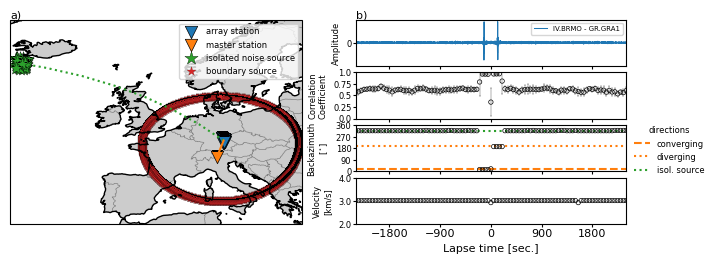

In [ ]:
import pylab as plt
from matplotlib.patches import Polygon
from matplotlib.gridspec import GridSpec
from pygc import great_circle

# plotting of results
cmap = plt.cm.tab10

_cm = 1 / 2.54
fig = plt.figure(figsize=(18 * _cm, 6.5 * _cm))
fig.subplots_adjust(left=0.0, right=0.9, bottom=0.15, top=0.95)
gs = GridSpec(4, 2, hspace=0.5, wspace=0, figure=fig)

plt.rc("font", size=8)
plt.rc("axes", titlesize=8)
plt.rc("axes", labelsize=8)
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)
plt.rc("legend", fontsize=6)
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# improve resolution of great circles
PC = ccrs.PlateCarree()
PC._threshold = PC._threshold / 10.0

# initialise map
ax = fig.add_subplot(gs[:, 0], projection=PC)
ax.add_feature(cfeature.LAND, facecolor="#CCCCCC")
ax.add_feature(cfeature.BORDERS, edgecolor="grey", linewidth=0.5, zorder=1)
ax.add_feature(cfeature.COASTLINE)

# plot stations onto map
ax.scatter(
    *coordinates.T,
    marker="v",
    s=80,
    transform=ccrs.PlateCarree(),
    color=cmap(0),
    ec="k",
    lw=0.5,
    label="array station",
)
ax.scatter(
    *settings["master_station_coords"],
    marker="v",
    s=80,
    transform=ccrs.PlateCarree(),
    color=cmap(1),
    ec="k",
    lw=0.5,
    label="master station",
)

# plot isolated sources onto map
if settings["type"] == "synthetics":
    for isolated_sources, ls in zip(isolated_sources_per_region, [":", "--"]):
        ax.scatter(
            *isolated_sources.T,
            marker="*",
            s=100,
            transform=ccrs.PlateCarree(),
            color=cmap(2),
            ec="k",
            lw=0.25,
        )
        mean_isolated_sources = np.mean(isolated_sources, axis=0)
        ax.plot(
            [settings["array_coords_mean"][0], mean_isolated_sources[0]],
            [settings["array_coords_mean"][1], mean_isolated_sources[1]],
            c=cmap(2),
            ls=ls,
            transform=ccrs.Geodetic(),
        )
    # for label only
    ax.scatter(
        [],
        [],
        marker="*",
        s=100,
        color=cmap(2),
        ec="k",
        lw=0.25,
        label="isolated noise source",
    )

    ax.scatter(
        *boundary_sources.T,
        marker="*",
        s=50,
        transform=ccrs.PlateCarree(),
        color=cmap(3),
        ec="k",
        lw=0.1,
        label="boundary source",
    )

# mark "other" direction on map
elif settings["type"] == "data":
    p1 = great_circle(
        distance=5000 * 1000,
        azimuth=300 - 50,
        latitude=settings["array_coords_mean"][1],
        longitude=settings["array_coords_mean"][0],
    )
    p2 = great_circle(
        distance=5000 * 1000,
        azimuth=300 + 20,
        latitude=settings["array_coords_mean"][1],
        longitude=settings["array_coords_mean"][0],
    )

    p1 = [p1["longitude"], p1["latitude"]]
    p2 = [p2["longitude"], p2["latitude"]]
    poly_corners = np.array([p1, p2, settings["array_coords_mean"]])
    poly = Polygon(
        poly_corners,
        closed=True,
        ec=cmap(2),
        fill=True,
        lw=1,
        fc=cmap(2),
        alpha=0.25,
        transform=ccrs.Geodetic(),
    )

    # add to map overlay
    ax.add_patch(poly)

# great-circle connection array and master station
ax.plot(
    [settings["master_station_coords"][0], settings["array_coords_mean"][0]],
    [settings["master_station_coords"][1], settings["array_coords_mean"][1]],
    c=cmap(1),
    transform=ccrs.Geodetic(),
)


ax.set_ylim(35, 70)
ax.set_xlim(-25, 25)
ax.set_title("a)", loc="left", pad=0)
ax.legend(loc=1)


# define axes for beamforming results based on map axis position
x0, y0, w, h = ax.get_position().bounds
full_height = h
ax_height = 0.9 * h / 4
space_inbetween_axes = (full_height - 4 * ax_height) / 3
bf_axs = [
    fig.add_axes(
        [
            x0 + w + 0.075,
            y0 + i * (ax_height + space_inbetween_axes),
            0.925 * w,
            ax_height,
        ]
    )
    for i in range(3, -1, -1)
]

for ax in bf_axs[:3]:
    ax.set_xticklabels([])

# sample correlation
ax = bf_axs[0]
ax.plot(
    lapsetimes,
    corrs_filt[0] / np.max(np.abs(corrs_filt[0])),
    lw=0.75,
    label=f"{settings['master_station']} - GR.GRA1",
)
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([0])
ax.set_yticklabels([0], fontsize=6)
ax.set_ylabel("Amplitude", fontsize=6)

ax.set_title("b)", loc="left", pad=0)
ax.legend(loc=0, fontsize=5)


# correlation coefficients
ax = bf_axs[1]
ax.scatter(
    windows + settings["window_length"] / 2,
    ccoeffs_mean,
    s=10,
    fc="None",
    ec="k",
    zorder=2,
    lw=0.5
)

ax.errorbar(
    windows + settings["window_length"] / 2,
    ccoeffs_mean,
    ecolor="#222",
    yerr=ccoeffs_std,
    capsize=1,
    elinewidth=0.25,
    capthick=0.25,
    lw=0,
)

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1 + 0.25, 0.25))
ax.set_yticklabels(np.arange(0, 1 + 0.25, 0.25), fontsize=6)
ax.set_ylabel("Correlation\nCoefficient", fontsize=6)

# best-beam backazimuth
ax = bf_axs[2]
ax.scatter(
    windows + settings["window_length"] / 2,
    peaks[:, 1] % 360,
    s=10,
    fc="None",
    ec="k",
    zorder=3,
    lw=0.5
)

ax.set_ylim(0, 360)
ax.set_yticks([0, 90, 180, 270, 360])
ax.set_yticklabels([0, 90, 180, 270, 360], fontsize=6)
ax.set_ylabel("Backazimuth\n" + r"[$^\circ$]", fontsize=6)

# mark directions for converging/diverging wavefield contribution
master_station_coords_baz = gps2dist_azimuth(
    *settings["master_station_coords"][::-1], *settings["array_coords_mean"][::-1]
)[2]
converging_az = (master_station_coords_baz % 360) % 180
diverging_az = (master_station_coords_baz % 180) + 180
if label == "Fig1_bottom":
    converging_az, diverging_az = diverging_az, converging_az
ax.axhline(converging_az, c=cmap(1), ls="--", label="converging", zorder=2)
ax.axhline(diverging_az, c=cmap(1), ls=":", label="diverging", zorder=2)

# mark directions for isolated noise sources
if settings["type"] == "data":
    ax.plot(
        [windows[0], windows[-1]],
        [300 - 50, 300 - 50],
        c=cmap(2),
        ls="-",
        label="other",
        zorder=1,
    )
    ax.plot(
        [windows[0], windows[-1]], [300 + 20, 300 + 20], c=cmap(2), ls="-", zorder=1
    )

    ax.fill_between(
        [windows[0], windows[-1]], y1=300 - 50, y2=300 + 20, fc=cmap(2), alpha=0.25
    )

elif settings["type"] == "synthetics":
    for center_lat, center_lon, ls in zip(
        settings["center_lats"], settings["center_lons"], [":", "--"]
    ):
        isolated_source_baz = gps2dist_azimuth(
            center_lat, center_lon, *settings["array_coords_mean"][::-1]
        )[2]
        ax.axhline(
            isolated_source_baz % 360, c=cmap(2), ls=ls, label="isol. source", zorder=1
        )

ax.legend(
    loc="upper left",
    fontsize=6,
    bbox_to_anchor=(1, 1.15),
    title="directions",
    title_fontsize=6,
    frameon=False,
)

# best-beam velocity
ax = bf_axs[-1]
ax.scatter(
    windows + settings["window_length"] / 2,
    peaks[:, 0],
    s=10,
    fc="None",
    ec="k",
    zorder=2,
    lw=0.5
)
ax.set_ylim(2, 4)
ax.set_yticks([2.0, 3, 4.0])
ax.set_yticklabels([2.0, 3.0, 4.0], fontsize=6)
ax.axhline(3, lw=0.5, c="#AAAAAA", ls=":", zorder=0)

ax.set_xlabel("Lapse time [sec.]")
ax.set_ylabel("Velocity\n" + "[km/s]", fontsize=6)

for ax in bf_axs:
    ax.xaxis.set_tick_params(length=2, pad=1)
    ax.yaxis.set_tick_params(length=2, pad=1)
    ax.set_xticks(np.arange(-3600, 3600 + 1, 900))
    ax.set_xlim(-2400, 2400)

outname = f"{label}_{settings['master_station']}"
fig.savefig(f"../figures/{outname}.pdf", dpi=300)